In [1]:
from datasets import DatasetDict, Dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    MarianMTModel,
    MarianTokenizer,
)
import evaluate
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import pandas as pd
from tqdm import tqdm
import gc
import GPUtil

2023-11-09 11:11:50.188005: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 11:11:50.188065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 11:11:50.188108: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Setting the DEVICE to cuda
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set path for raw dataset dictionary
RAW_DATASET_PATH = "../data/processed/raw_dataset.pkl"

# Load tokenizers and models
tokenizer_toxicity = RobertaTokenizer.from_pretrained("SkolkovoInstitute/roberta_toxicity_classifier")
model_toxicity = RobertaForSequenceClassification.from_pretrained("SkolkovoInstitute/roberta_toxicity_classifier").to(DEVICE)
tokenizer_acceptability = AutoTokenizer.from_pretrained("iproskurina/tda-bert-en-cola")
model_acceptability = AutoModelForSequenceClassification.from_pretrained("iproskurina/tda-bert-en-cola").to(DEVICE)

# Load dataset
raw_datasets = DatasetDict.load_from_disk(RAW_DATASET_PATH)

# Set batch size
BATCH_SIZE = 64

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
def get_gpu_memory():
    """
    Gets the GPU memory information.
    """
    gpus = GPUtil.getGPUs()
    gpu = gpus[0]
    print(f"Total GPU memory: {gpu.memoryTotal}MB")
    print(f"Free GPU memory: {gpu.memoryFree}MB")
    print(f"Used GPU memory: {gpu.memoryUsed}MB")

def cleanup():
    """
    Cleans up the GPU memory.
    """
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
get_gpu_memory()

Total GPU memory: 23034.0MB
Free GPU memory: 20429.0MB
Used GPU memory: 2088.0MB


# Evaluation Functions

In [5]:
# Initialize model variables
model_bleurt = None
model_bertscore = None
model_sacrebleu = None

def calc_sacrebleu(refs, preds):
    """
    Calculates the SacreBLEU score.

    Args:
        refs (list): List of reference sentences
        preds (list): List of predicted sentences
    
    Returns:
        results (float): SacreBLEU score
    """
    global model_sacrebleu

    if model_sacrebleu is None:
        model_sacrebleu = evaluate.load("sacrebleu")

    results = model_sacrebleu.compute(predictions=preds, references=refs)["score"]
    results = results/100

    return results

def calc_bert_score(
    refs, preds, model_type="microsoft/deberta-large-mnli", output_mean=True
    ):
    """
    Calculates BERT score per line. Note: https://docs.google.com/spreadsheets/d/1RKOVpselB98Nnh_EOC4A2BYn8_201tmPODpNWu4w7xI/edit#gid=0 lists the best performing models
    Args:
        refs (list): List of reference sentences.
        y_pred (list): List of predicted sentences.
        model_type (str): Type of BERT model to use.
        output_mean (bool): Whether to output the mean of the scores.

    Returns:
        list of precision, recall, f1 scores.

    """
    global model_bertscore

    if model_bertscore is None:
        model_bertscore = evaluate.load("bertscore")
        
    results = model_bertscore.compute(predictions=preds, references=refs, model_type=model_type)
    precision = np.array(results["precision"])
    recall = np.array(results["recall"])
    f1 = np.array(results["f1"])
    
    if output_mean:
        precision = precision.mean()
        recall = recall.mean()
        f1 = f1.mean()

    return precision, recall, f1

def calc_bleurt(refs, preds, checkpoint="BLEURT-20_D12", output_mean = True):
    """
    Calculates BLEURT score per line.

    Args:
        refs (list): List of reference sentences.
        preds (list): List of predicted sentences.
        output_type (str): Type of output to return. Either 'numpy' or 'list'.

    Returns:
        list/array of BLEURT scores.
    """
    global model_bleurt

    if model_bleurt is None:
        model_bleurt = evaluate.load("bleurt", module_type="metric", checkpoint=checkpoint)

    results = np.array(model_bleurt.compute(predictions=preds, references=refs)["scores"])

    if output_mean:
        results = results.mean()

    return results

def calc_tox_acceptability(
    data,
    tokenizer,
    model,
    output_score=True,
    output_mean=True):
    """
    Calculates toxicity and acceptability scores for a given dataset.

    Args:
        data = list of strings to be evaluated
        tokenizer = tokenizer for the model
        model = model to be used for evaluation
        output_score = whether to output the score or the label
        output_mean = whether to output the mean of the scores or the scores for each sentence
    
    Returns:
        array of toxicity and acceptability scores.
    """  
    inputs = tokenizer(data, return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs)["logits"]
        if output_score:
            result = torch.nn.functional.softmax(logits, dim=1)[:, 1]
        else:
            result = logits.argmax(1).data
        result = result.cpu().numpy()

    if output_mean:
        result = result.mean()
        
    return result

def evaluate_metrics(
    refs,
    preds,
    tokenizer_toxicity=tokenizer_toxicity,
    model_toxicity=model_toxicity,
    tokenizer_acceptability=tokenizer_acceptability,
    model_acceptability=model_acceptability,
    to_neutral=True,
    weights={
        "BLEU": 0.2,
        "STA": 0.4,
        "Acceptability": 0.2,
        "BERT_Score": 0.2
    },
    include_bleurt=False
):
    """
    Calculates and returns a dictionary of evaluation metrics

    Args:
        refs (list): list of strings (reference)
        preds (list): list of strings (predictions)
        tokenizer_toxicity (tokenizer): tokenizer for toxicity model
        model_toxicity (model): toxicity model
        tokenizer_acceptability (tokenizer): tokenizer for acceptability model
        model_acceptability (model): acceptability model
        to_neutral (bool): whether the goal is to transfer to neutral (True) or to toxic (False)
        weights (dict): dictionary of weights for each metric
        include_bleurt (bool): whether to include BLEURT score in the output

    Returns:
        results (dict): dictionary of evaluation metrics
    """

    # Calculate BLEU score
    bleu = calc_sacrebleu(refs, preds)

    # Calculate toxicity classification
    # tox_ref = calc_tox_acceptability(refs, tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)
    tox_pred = calc_tox_acceptability(preds, tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)

    # Calculate style transfer accuracy as proportion of sentences that were correctly classified (as non-toxic / toxic)
    if to_neutral:
        sta_correct_label = 0
    else:
        sta_correct_label = 1

    # sta_ref = (tox_ref == sta_correct_label).sum() / len(tox_ref)
    sta_pred = (tox_pred == sta_correct_label).sum() / len(tox_pred)
    # sta_pct = sta_pred / sta_ref

    # Calculate acceptability scores
    # acc_ref = calc_tox_acceptability(refs, tokenizer_acceptability, model_acceptability)
    acc_pred = calc_tox_acceptability(preds, tokenizer_acceptability, model_acceptability)
    # acc_pct = acc_pred / acc_ref

    # Calculate similarity score
    bert_score_f1 = calc_bert_score(refs, preds, model_type="distilbert-base-uncased")[2]

    # Calculate BLEURT score if include_bleurt is True
    bleurt = None
    if include_bleurt:
        bleurt = calc_bleurt(refs, preds)

    # Calculate composite score
    composite_score = weights["BLEU"] * bleu + weights["STA"] * sta_pred + weights["Acceptability"] * acc_pred + weights["BERT_Score"] * bert_score_f1

    # Return a dictionary of metrics
    results = {
        "BLEU": bleu,
        "STA": sta_pred,
        # "STA_pct": sta_pct,
        "FLU": acc_pred,
        # "Acceptability_pct": acc_pct,
        "SEM": bert_score_f1,
        "Overall": composite_score,
    }
    if include_bleurt:
        results["BLEURT"] = bleurt
        
    return results


# Back-Translation Functions

In [6]:
from tqdm import tqdm

# Helper function to download data for a language
def download(model_name):
  tokenizer = MarianTokenizer.from_pretrained(model_name)
  model = MarianMTModel.from_pretrained(model_name)
  return tokenizer, model

# download model for English -> Romance
tmp_lang_tokenizer, tmp_lang_model = download('Helsinki-NLP/opus-mt-en-ROMANCE')

# download model for Romance -> English
src_lang_tokenizer, src_lang_model = download('Helsinki-NLP/opus-mt-ROMANCE-en')

# Move models to GPU
src_lang_model.to(DEVICE)
tmp_lang_model.to(DEVICE)

def translate(batch_texts, model, tokenizer, language):
    """
    Translate texts into a target language
    
    Args:
        batch_texts (list): list of texts to be translated
        model (model): MarianMTModel
        tokenizer (tokenizer): MarianTokenizer
        language (str): target language

    Returns:
        list of translated texts
    """
    formatter_fn = lambda txt: f">>{language}<<" + txt if language != "en" else txt
    formatted_texts = [formatter_fn(txt) for txt in batch_texts]

    tokens = tokenizer(formatted_texts, return_tensors="pt", padding=True, truncation=True).to(DEVICE)

    with torch.no_grad():
        translated = model.generate(**tokens)

    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)

    # Delete unnecessary variables and clear GPU memory
    del tokens
    del translated
    cleanup()

    return translated_texts

def back_translate(texts, language_src, language_dst, batch_size=BATCH_SIZE):
    """
    Implements back translation using batch processing
    
    Args:
        texts (list): list of texts to be back translated
        language_src (str): source language
        language_dst (list): list of target languages
        batch_size (int): batch size

    Returns:
        list of back translated texts    
    """
    all_back_translated_texts = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        for lang in language_dst:
            translated_batch = translate(batch, tmp_lang_model, tmp_lang_tokenizer, lang)
            back_translated_batch = translate(translated_batch, src_lang_model, src_lang_tokenizer, language_src)
            all_back_translated_texts.extend(back_translated_batch)

    return all_back_translated_texts

# EDA to set tresholds for filters

Acceptability

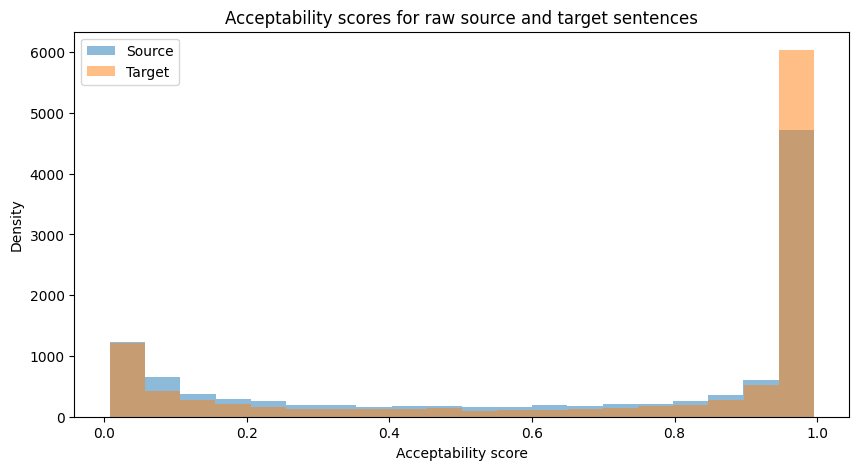

acceptability_threshold_source: 0.6541633009910583
acceptability_threshold_target: 0.7226778864860535


In [7]:
# Get acceptability scores for raw source and target sentences
raw_src_acceptability = calc_tox_acceptability(raw_datasets["train"]["source"], tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
raw_tgt_acceptability = calc_tox_acceptability(raw_datasets["train"]["target"], tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)

# Plot in density plots
plt.figure(figsize=(10, 5))
plt.title("Acceptability scores for raw source and target sentences")
plt.xlabel("Acceptability score")
plt.ylabel("Density")
plt.hist(raw_src_acceptability, bins=20, alpha=0.5, label="Source")
plt.hist(raw_tgt_acceptability, bins=20, alpha=0.5, label="Target")
plt.legend()
plt.show()

# Calculate acceptability thresholds
ACCEPTABILITY_THRESHOLD_SOURCE = np.mean(raw_src_acceptability)
ACCEPTABILITY_THRESHOLD_TARGET = np.mean(raw_tgt_acceptability)

print(f"acceptability_threshold_source: {ACCEPTABILITY_THRESHOLD_SOURCE}")
print(f"acceptability_threshold_target: {ACCEPTABILITY_THRESHOLD_TARGET}")

Semantic similarity

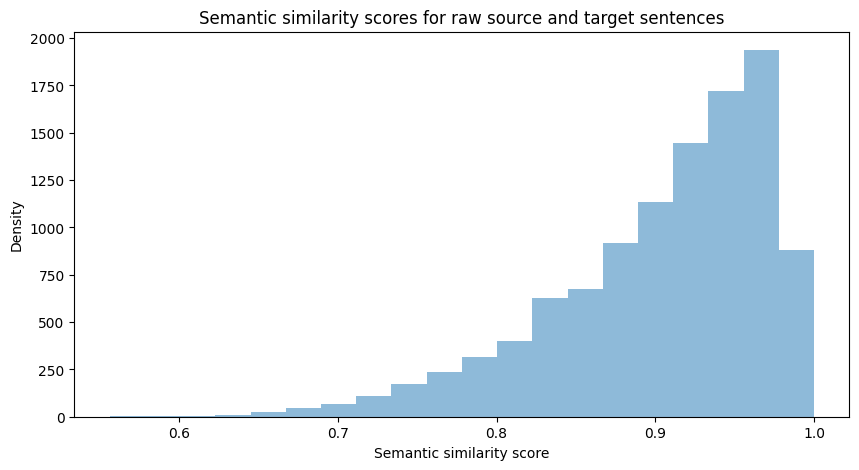

similarity_threshold: 0.9040371657450779


In [8]:
# Calculate semantic similarity scores for raw source and target sentences
raw_similarity = calc_bert_score(raw_datasets["train"]["source"], raw_datasets["train"]["target"], model_type="distilbert-base-uncased", output_mean=False)[2]

# Plot in density plots
plt.figure(figsize=(10, 5))
plt.title("Semantic similarity scores for raw source and target sentences")
plt.xlabel("Semantic similarity score")
plt.ylabel("Density")
plt.hist(raw_similarity, bins=20, alpha=0.5)
plt.show()

# Calculate semantic similarity threshold
SIMILARITY_THRESHOLD = np.mean(raw_similarity)
print(f"similarity_threshold: {SIMILARITY_THRESHOLD}")

# Back-Translation Implementation

In [9]:
# For testing, create raw_train_dataset with 256 samples
raw_train_dataset = raw_datasets["train"].shuffle().select(range(256))
print(f"Length of raw_train_dataset: {len(raw_train_dataset)}")

Length of raw_train_dataset: 256


## 1. Make back-translated dataframe

In [10]:
def make_back_translate_df(raw_train_dataset=raw_train_dataset,
                           language_src = "en",
                           language_dst = ['fr', 'es', 'it', 'pt']):
    
    # Create a pandas dataframe
    df = pd.DataFrame()

    # Back translate the sentences and add to pandas dataframe
    df['source_bt'] = back_translate(raw_train_dataset['source'], language_src, language_dst)
    df['target_bt'] = back_translate(raw_train_dataset['target'], language_src, language_dst)

    # Delete rows with duplicate 'source_bt' or 'target_bt'
    df = df.drop_duplicates(subset=['source_bt'])
    df = df.drop_duplicates(subset=['target_bt'])
    
    return df

# Create a dataframe for back translated sentences
df_backtranslated = make_back_translate_df()

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [01:26<00:00, 21.51s/it]


In [11]:
get_gpu_memory()

# Delete models and clear GPU memory
del tmp_lang_model
del tmp_lang_tokenizer
del src_lang_model
del src_lang_tokenizer
cleanup()

get_gpu_memory()

Total GPU memory: 23034.0MB
Free GPU memory: 18751.0MB
Used GPU memory: 3766.0MB
Total GPU memory: 23034.0MB
Free GPU memory: 19335.0MB
Used GPU memory: 3182.0MB


## 2. Add filters to the back-translated dataframe

In [12]:
def calc_filters(df, acceptability_threshold_source=ACCEPTABILITY_THRESHOLD_SOURCE, acceptability_threshold_target=ACCEPTABILITY_THRESHOLD_TARGET, similarity_threshold=SIMILARITY_THRESHOLD):
    # Calculate toxicity scores for the candidate sentence pairs
    df['source_bt_toxicity'] = calc_tox_acceptability(df['source_bt'].tolist(), tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)
    df['target_bt_toxicity'] = calc_tox_acceptability(df['target_bt'].tolist(), tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)

    # Calculate acceptability scores for the candidate sentence pairs
    df['source_bt_acceptability'] = calc_tox_acceptability(df['source_bt'].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
    df['target_bt_acceptability'] = calc_tox_acceptability(df['target_bt'].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)

    # Calculate similarity scores for the candidate sentence pairs - return the F1 score
    df['bt_similarity'] = calc_bert_score(df['source_bt'], df['target_bt'], model_type="distilbert-base-uncased", output_mean=False)[2]

    # Create filters for the candidate sentence pairs
    ## Filter 1: Toxicity
    df['f_toxicity'] = (df['source_bt_toxicity'] == 1) & (df['target_bt_toxicity'] == 0)

    ## Filter 2: Acceptability
    df['f_acceptability'] = (df['source_bt_acceptability'] >= acceptability_threshold_source) & (df['target_bt_acceptability'] >= acceptability_threshold_target)

    ## Filter 3: Similarity
    df['f_similarity'] = (df['bt_similarity'] >= similarity_threshold)
  
    # Delete redundant columns
    df = df.drop(columns=['source_bt_toxicity', 'target_bt_toxicity', 'source_bt_acceptability', 'target_bt_acceptability', 'bt_similarity'])

    return df

df_backtranslated_with_filters = calc_filters(df_backtranslated)

In [13]:
get_gpu_memory()

# Delete models and clear GPU memory
del tokenizer_toxicity
del model_toxicity
del tokenizer_acceptability
del model_acceptability
cleanup()

get_gpu_memory()

Total GPU memory: 23034.0MB
Free GPU memory: 6733.0MB
Used GPU memory: 15784.0MB
Total GPU memory: 23034.0MB
Free GPU memory: 19335.0MB
Used GPU memory: 3182.0MB


## 3. Create different dataframes applying different filters

In [41]:
def create_filtered_df(df, f_toxicity, f_acceptability, f_similarity, raw_train_dataset=raw_train_dataset):
    """
    Creates a filtered dataframe based on the filters provided, adds the original source and target sentences, removes duplicates, and returns the dataframe.

    Args:
        df (dataframe): dataframe to be filtered
        f_toxicity (bool): whether to filter based on toxicity
        f_acceptability (bool): whether to filter based on acceptability
        f_similarity (bool): whether to filter based on similarity

    Returns:
        filtered dataframe
    """
    # Create a copy of the dataframe
    df = df.copy()

    # Apply filters
    if f_toxicity:
        df = df[df['f_toxicity'] == True]
    if f_acceptability:
        df = df[df['f_acceptability'] == True]
    if f_similarity:
        df = df[df['f_similarity'] == True]

    # Drop filter columns
    df = df.drop(columns=['f_toxicity', 'f_acceptability', 'f_similarity'])

    # Concatenate the original source and target sentences into source_bt and target_bt
    df = pd.concat([df, pd.DataFrame({'source_bt': raw_train_dataset['source'], 'target_bt': raw_train_dataset['target']})], axis=0)
          
    # Delete rows with duplicate 'source_bt' or 'target_bt'
    df = df.drop_duplicates(subset=['source_bt'])
    df = df.drop_duplicates(subset=['target_bt'])

    # Rename columns
    df = df.rename(columns={'source_bt': 'source', 'target_bt': 'target'})
    
    # Reset index
    df = df.reset_index(drop=True)

    return df

# Create a dataframe applying all filters
df_all_filters = create_filtered_df(df=df_backtranslated_with_filters, f_toxicity=True, f_acceptability=True, f_similarity=True)
print(f"Number of rows in dataframe with all filters: {len(df_all_filters)}")

# Create a dataframe without toxicity filter
df_no_toxicity_filter = create_filtered_df(df=df_backtranslated_with_filters, f_toxicity=False, f_acceptability=True, f_similarity=True)
print("Number of rows in dataframe with no toxicity filter: ", len(df_no_toxicity_filter))

# Create a dataframe without acceptability filter
df_no_acceptability_filter = create_filtered_df(df=df_backtranslated_with_filters, f_toxicity=True, f_acceptability=False, f_similarity=True)
print("Number of rows in dataframe with no acceptability filter: ", len(df_no_acceptability_filter))

# Create a dataframe without similarity filter
df_no_similarity_filter = create_filtered_df(df=df_backtranslated_with_filters, f_toxicity=True, f_acceptability=True, f_similarity=False)
print("Number of rows in dataframe with no similarity filter: ", len(df_no_similarity_filter))

Number of rows in dataframe with all filters: 387
Number of rows in dataframe with no toxicity filter:  463
Number of rows in dataframe with no acceptability filter:  448
Number of rows in dataframe with no similarity filter:  549


In [45]:
# Set maximum number of rows to be saved for each dataset dictionary
MAX_ROWS = len(df_all_filters)

# Create dataset dictionaries based on filtered dataframes. Note: the validation and test sets are the same for all datasets.
aug_datasets_all_filters = DatasetDict({
    "train": Dataset.from_pandas(df_all_filters).shuffle().select(range(MAX_ROWS)),
    "validation": raw_datasets["validation"],
    "test": raw_datasets["test"]
})

# Randomly sample MAX_ROWS from df_no_toxicity_filter, df_no_acceptability_filter, and df_no_similarity_filter
aug_datasets_no_tox_filter = DatasetDict({
    "train": Dataset.from_pandas(df_no_toxicity_filter).shuffle().select(range(MAX_ROWS)),
    "validation": raw_datasets["validation"],
    "test": raw_datasets["test"]
})

aug_datasets_no_acc_filter = DatasetDict({
    "train": Dataset.from_pandas(df_no_acceptability_filter).shuffle().select(range(MAX_ROWS)),
    "validation": raw_datasets["validation"],
    "test": raw_datasets["test"]
})

aug_datasets_no_sim_filter = DatasetDict({
    "train": Dataset.from_pandas(df_no_similarity_filter).shuffle().select(range(MAX_ROWS)),
    "validation": raw_datasets["validation"],
    "test": raw_datasets["test"]
})